In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# 1. Loading images

Text(0.5, 1.0, 'Depth map of image 1')

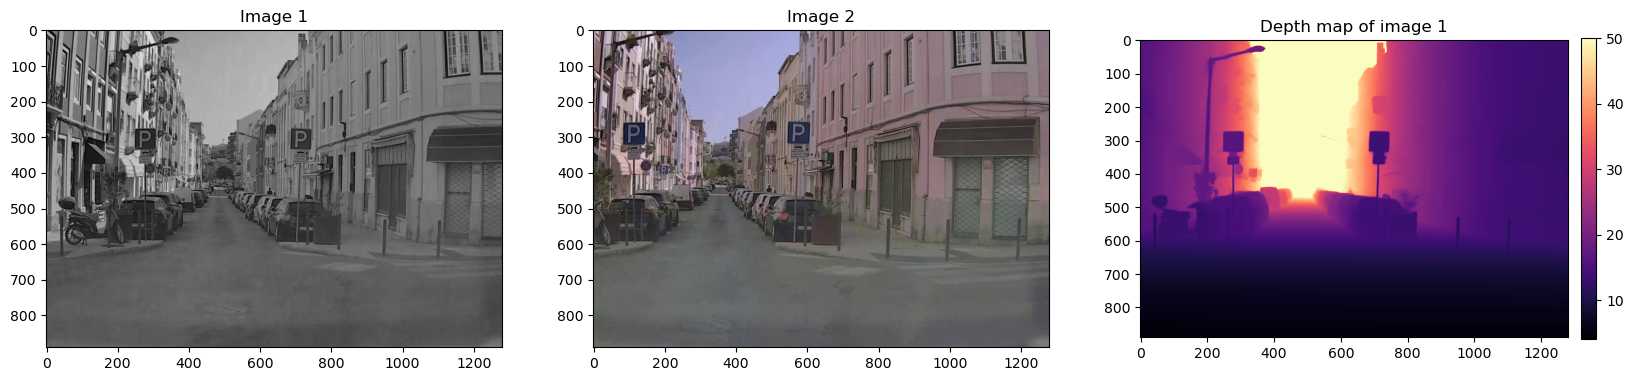

In [2]:
img1 = np.array(Image.open('320.jpg'))
img2 = np.array(Image.open('330.jpg'))
depth1 = np.load('320_depth.npy')

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.title("Image 1")
plt.subplot(1,3,2)
plt.imshow(img2)
plt.title("Image 2")
plt.subplot(1,3,3)
plt.imshow(depth1, cmap="magma")
plt.colorbar(fraction=0.033, pad=0.03)
plt.title("Depth map of image 1")

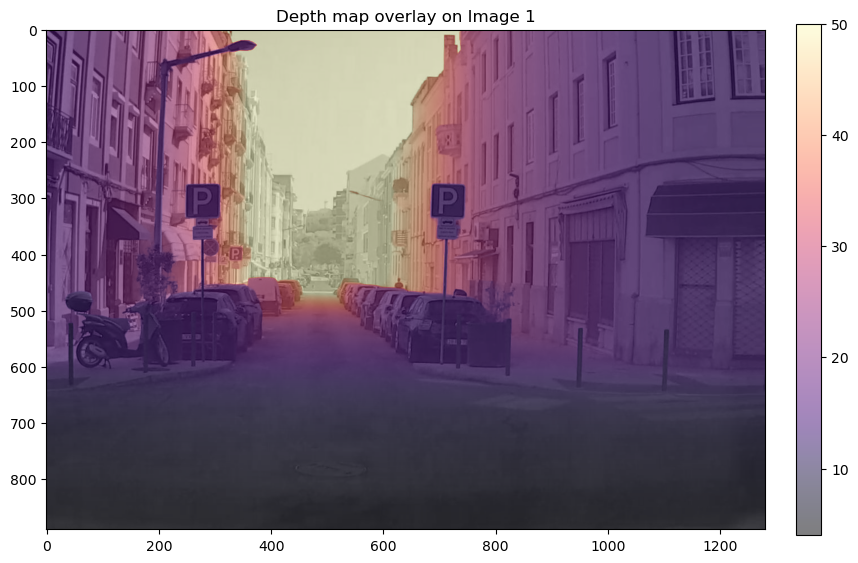

In [3]:
plt.figure(figsize=(10, 10))
plt.imshow(img1)
plt.imshow(depth1, cmap='magma', alpha=0.5)
plt.colorbar(fraction=0.033, pad=0.04)
plt.title("Depth map overlay on Image 1")
plt.show()

# 2. Building black and white point cloud

In [ ]:
# Going from pixel space to meters
f = 1180
cy = img1.shape[0] / 2
cx = img1.shape[1] / 2 
print(f"cy: {cy}, cx: {cx}")

pcloud_bw = []

# Iterative
for y in range(img1.shape[0]):
    for x in range(img1.shape[1]):
        pcloud_bw.append([
            (x - cx) * depth1[y, x] / f,
            (y - cy) * depth1[y, x] / f,
            depth1[y, x]]
        )

cy: 445.0, cx: 640.0


In [5]:
np.array(pcloud_bw).shape

(1139200, 3)

In [6]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcloud_bw)
pcd.colors = o3d.utility.Vector3dVector(img1.reshape(-1, 3) / 255)
o3d.io.write_point_cloud(f"./black_white_pc.ply", pcd)

True

# 3. Finding rigid body transformation

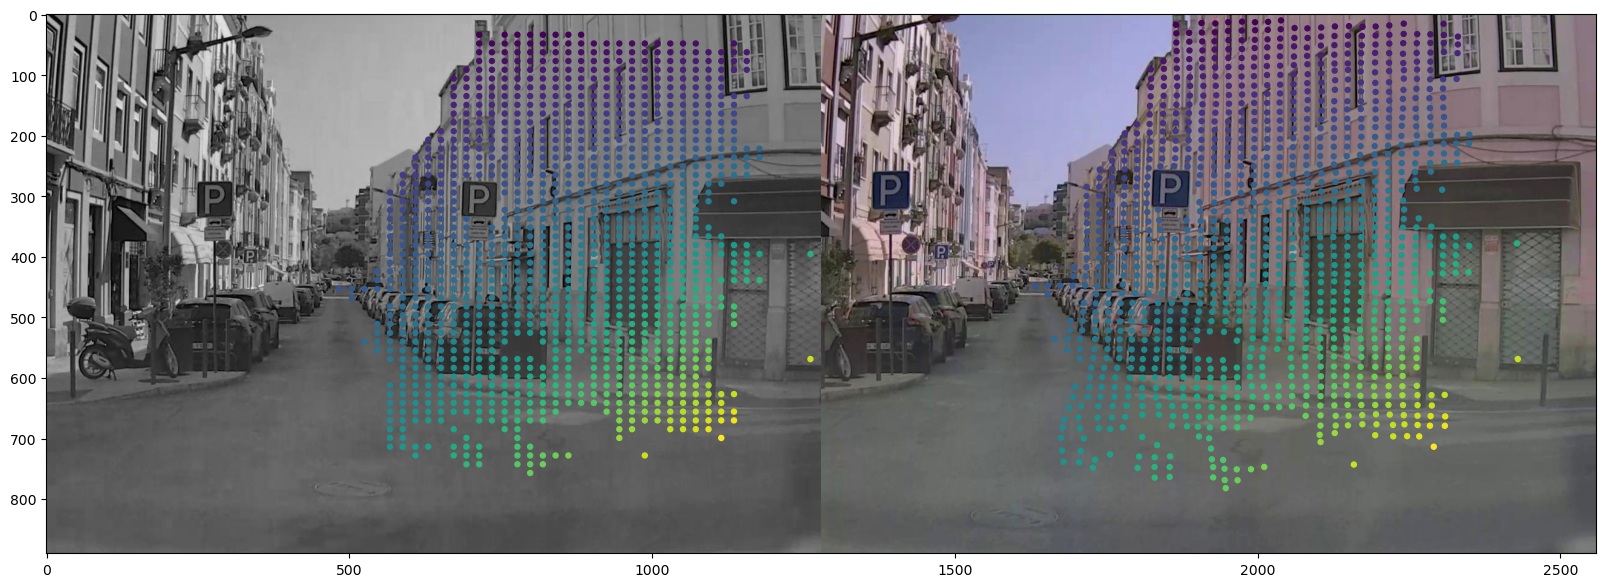

In [7]:
matches = np.load("320_330_matches.npy")

cmap = matplotlib.colormaps['Spectral']
plt.figure(figsize=(20,10))
side_by_side = np.concatenate((img1, img2), axis=1)
plt.imshow(side_by_side)
plt.scatter(matches[:,0,0], matches[:,1,0], 13, c=matches[:,0,0] * matches[:,1,0])
plt.scatter(matches[:,0,1] + img1.shape[1], matches[:,1,1], 13, c=matches[:,0,0] * matches[:,1,0])

In [8]:
# Visualizing an example match
# Note a lot of translation in the x-axis. Some less in the y-axis
x1,y1 = matches[0,:,0]
x2,y2 = matches[0,:,1]
print(f"Match: {x1,y1} -> {x2,y2}")

Match: (714.39716, 33.046864) -> (585.19385, 16.558245)


In [9]:
match_img1 = matches[:,:,0]
match_img2 = matches[:,:,1]

In [10]:
cxy_img1 = match_img1.mean(axis=0)
cxy_img2 = match_img2.mean(axis=0)
translation = cxy_img2 - cxy_img1

match_img1_centered = match_img1 - cxy_img1
match_img2_centered = match_img2 - cxy_img2

In [11]:
from scipy.linalg import svd

# Least squares closed solution for the rotation
cross_covariance = match_img1_centered.T @ match_img2_centered
U, S, Vt = svd(cross_covariance)
rotation = Vt.T @ U.T

assert np.allclose(rotation @ rotation.T, np.eye(rotation.shape[0]), atol=1e-5)
assert np.linalg.det(rotation) > 0
assert np.isclose(np.linalg.det(rotation), 1, atol=1e-4)

In [12]:
# Testing a point
print(match_img2[0])
print(rotation @ match_img1[0] + translation)

[585.19385   16.558245]
[588.77246   23.863724]


In [13]:
# Calculating rms error
((match_img1 @ rotation.T + translation - match_img2) ** 2).mean()

107.05161

# 4. Applying transformation to img2

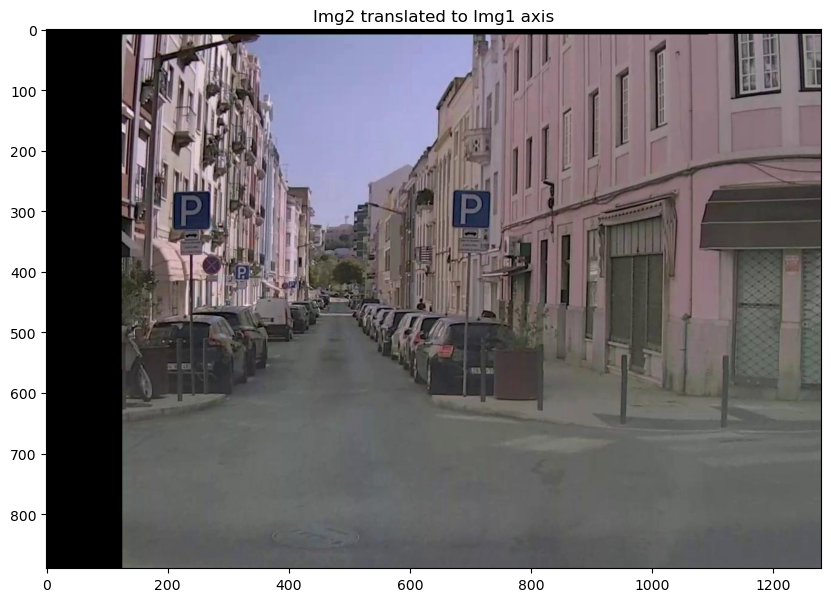

In [14]:
rot_inv = np.linalg.inv(rotation)
new_img2 = np.zeros_like(img2)

for x in range(img2.shape[1]):
    for y in range(img2.shape[0]):
        new_x,new_y = rot_inv @ np.array([x,y]) - translation
        if 0 <= new_x < img1.shape[1] and 0 <= new_y < img1.shape[0]:
            new_img2[int(new_y),int(new_x)] = img2[int(y), int(x)]


plt.figure(figsize=(10, 10))
plt.imshow(new_img2)
plt.title("Img2 translated to Img1 axis")
plt.show()

# 5. Coloring img1 when possible

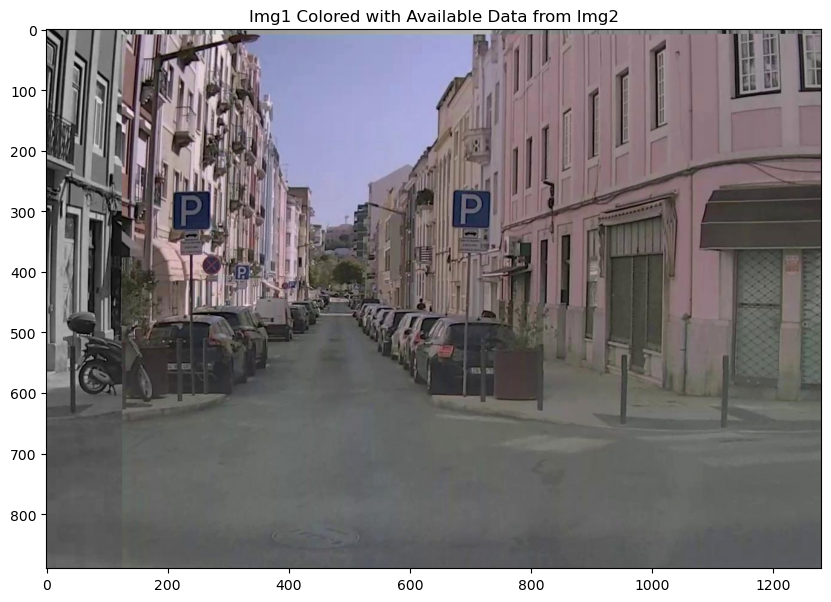

In [15]:
colors_img1 = img1.reshape(-1, 3) / 255
colors_img2 = new_img2.reshape(-1, 3) / 255
black_pixels_mask = np.all(colors_img2 == 0, axis=1)

colors_final = colors_img2.copy()
colors_final[black_pixels_mask] = colors_img1[black_pixels_mask] 

colored_img1 = colors_final.reshape(img1.shape)

plt.figure(figsize=(10, 10))
plt.imshow(colored_img1)
plt.title("Img1 Colored with Available Data from Img2")
plt.show()

# 6. Exporting point cloud

In [16]:
colors_final

array([[0.73333333, 0.73333333, 0.73333333],
       [0.54509804, 0.54509804, 0.54509804],
       [0.34901961, 0.34901961, 0.34901961],
       ...,
       [0.37254902, 0.37647059, 0.39607843],
       [0.37254902, 0.37647059, 0.39215686],
       [0.37254902, 0.37647059, 0.39215686]])

In [17]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcloud_bw)
pcd.colors = o3d.utility.Vector3dVector(colors_final)
o3d.io.write_point_cloud(f"./colored_pc.ply", pcd)

True